In [134]:
import numpy as np

import scipy as sp
import scipy.sparse
import scipy.sparse.linalg

import sklearn
import sklearn.preprocessing

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import networkx as nx

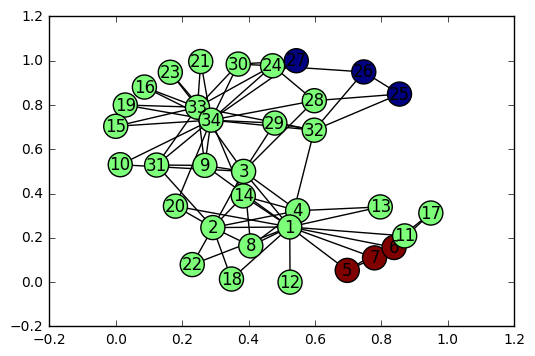

In [180]:
# karate network dataset

kn = nx.read_gml("karate.gml")
A = nx.adjacency_matrix(kn).todense()
nodes = [int(i) for i in kn.nodes()]
d = np.zeros(34)
d[nodes.index(5)] = d[nodes.index(6)] = d[nodes.index(7)] = 1
d[nodes.index(25)] = d[nodes.index(26)] = d[nodes.index(27)] = -1


nx.draw_networkx(kn, node_color=d)

In [181]:
# preprocessing

F = sklearn.preprocessing.normalize(A, axis=1, norm='l1')
B = sklearn.preprocessing.normalize(A.T, axis=1, norm='l1')

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [182]:
a1 = 0.7
a2 = 0.7
a3 = 0.7

In [183]:
# we are looking for solution x == T(x)

def T(F, B, d, x):
    return a1 * F.dot(x.clip(0)) + a2 * B.dot(x.clip(-np.inf, 0)) + a3 * d

In [184]:
# RepRank

def RepRank(F, B, d, maxiter=200, x0=None, tol=1e-8, callback=None):
    if x0 is None:
        x_prev = d.copy()
    else:
        x_prev = x0.copy()

    for k in range(maxiter):
        x_next = T(F, B, d, x_prev)
        n = np.linalg.norm(x_next - x_prev)
        if callback is not None:
            callback(x_next, n)
        if n < tol:
            break
        x_prev = x_next

    ans = x_next.copy()
    return(k + 1, ans.reshape(-1,))

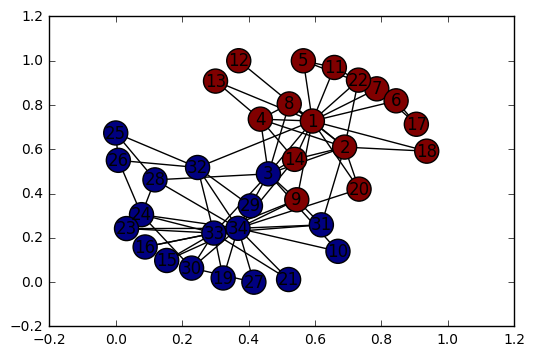

In [187]:
k, ans = RepRank(F, B, d)

ans[ans > 0] = 1
ans[ans < 0] = -1

nx.draw_networkx(gr, node_color=ans)

In [189]:
def h(x):
    ans = np.zeros_like(x)
    ans[x > 0.0] = 1.0
    return ans

In [190]:
def obj(x):
    return np.linalg.norm(x - T(F, B, d, x)) ** 2 / 2

In [191]:
def der(x):
    l = x - T(F, B, d, x)
    lF = F.T.dot(l)
    lB = B.T.dot(l)
    return l - a1 * np.multiply(lF, h(x)) - a2 * np.multiply(lB, h(-x))

In [192]:
def LineSearch(x, dx):
    alpha = obj(x) / np.linalg.norm(dx) ** 2
    while True:
        if obj(x + alpha * dx) < obj(x):
            return x + alpha * dx
        else:
            alpha /= 2

In [194]:
x_prev = d.copy()
x_next = x_prev.copy()

for k in range(100):
    dx = der(x_prev)
    #x_next = LineSearch(x_prev, -dx)
    x_next = x_prev - dx * obj(x_prev) / np.linalg.norm(dx) ** 2
    if obj(x_next) < 1e-8:
        break
    print(k, np.linalg.norm(x_next - x_prev), obj(x_next))
    x_prev = x_next.copy()

0 0.431254626801 0.148125185022
1 0.311136332355 0.0702763780514
2 0.377266400334 0.05606379856
3 0.146735975587 0.0288095896602
4 0.213287387977 0.0387808000508
5 0.100174436071 0.0163084607645
6 0.175665491194 0.0207821551999
7 0.0801356882819 0.00912951328096
8 0.123020636974 0.0100291382377
9 0.067541382006 0.00518150702322
10 0.0863894030601 0.0085737476757
11 0.044950281118 0.00341182379786
12 0.0740586375731 0.00581792542565
13 0.0368555577481 0.0022596475792
14 0.055059640308 0.00335723783227
15 0.0300766191161 0.0014650266288
16 0.0604564504117 0.00219374369745
17 0.025145159265 0.000853555124065
18 0.0321729819088 0.000825651235878
19 0.0223940122361 0.000537706678453
20 0.0252225027496 0.000741099395518
21 0.0155059496381 0.000346171765765
22 0.0396257191789 0.000255015194925
23 0.00890737037613 0.000108964875487
24 0.0145621350059 0.00015244120323
25 0.00776717939093 6.8001956061e-05
26 0.0115977323385 0.000119368648956
27 0.00564623849768 4.82940543227e-05
28 0.00818086994

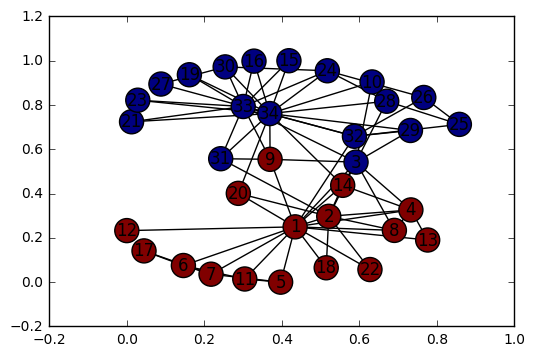

In [195]:
ans = x_prev.copy()
ans[x_prev > 0] = 1
ans[x_prev < 0] = -1

nx.draw_networkx(gr, node_color=ans)

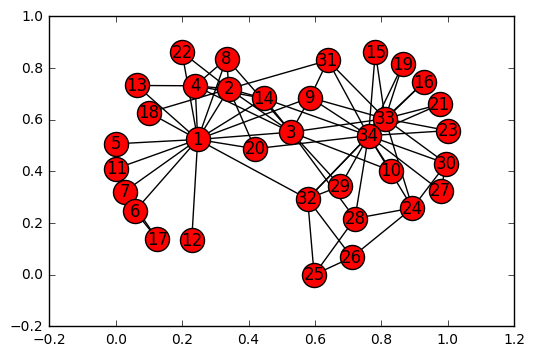

In [157]:
#np.savetxt("1.txt", A, fmt="%0d")

In [113]:
# preprocessing

F = sklearn.preprocessing.normalize(A, axis=1, norm='l1')
B = sklearn.preprocessing.normalize(A.T, axis=1, norm='l1')

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [45]:
np.linalg.norm(ans - T(F, B, d, ans))

5.0822908191887304e-09

In [47]:
np.linalg.norm(der(ans))

4.6968612875355639e-09

In [57]:
for k in range(100):
    x_next = x_prev - der(x_prev)
    x_prev = x_next.copy()
    if np.linalg.norm(der(x_prev)) < 1e-5:
        break
    print(k, np.linalg.norm(der(x_prev)), np.linalg.norm(x_next - T(F, B, d, x_next)))

0 11.7849339698 8.20545185553
1 14.4018524787 15.6038223142
2 64.2822112135 16.0489443913
3 69.9685429838 63.7108830105
4 156.611622573 49.1424491042
5 1120.33359962 296.868823711
6 11681.5271003 2541.41688694
7 91147.1925577 25132.7998683
8 1432782.12907 252412.024622
9 9758317.01383 2981002.24464
10 199618017.421 31811470.854
11 1271245576.61 408321432.198
12 28159631011.9 4424666653.43
13 178722969417.0 58053268061.5
14 4.12988912687e+12 636627682918.0
15 2.5770160934e+13 8.42696747741e+12
16 5.91225056091e+14 9.20057296144e+13
17 3.72715624764e+15 1.21680452304e+15
18 8.64586600918e+16 1.33501442135e+16
19 5.40755255312e+17 1.76902174242e+17
20 1.24768898752e+19 1.9353294567e+18
21 7.84081716154e+19 2.56219422017e+19
22 1.82136645291e+21 2.80954400874e+20


KeyboardInterrupt: 

In [54]:
np.linalg.norm(x_next - T(F, B, d, x_next))

9.5767795408787517